<div style="height:100px">

<div style="display:inline-block; width:77%; vertical-align:middle;">
    <div>
        <b>Author</b>: <a href="http://pages.di.unipi.it/castellana/">Daniele Castellana</a>
    </div>
    <div>
        PhD student at the Univeristy of Pisa and member of the Computational Intelligence & Machine Learning Group (<a href="http://www.di.unipi.it/groups/ciml/">CIML</a>)
    </div>
    <div>
        <b>Mail</b>: <a href="mailto:daniele.castellana@di.unipi.it">daniele.castellana@di.unipi.it</a>
    </div>
</div>

<div style="display:inline-block; width: 10%; vertical-align:middle;">
    <img align="right" width="100%" src="https://upload.wikimedia.org/wikipedia/it/7/72/Stemma_unipi.png">
</div>

<div style="display:inline-block; width: 10%; vertical-align:middle;">
    <img align="right" width="100%" src="http://www.di.unipi.it/groups/ciml/Home_files/loghi/logo_ciml-restyling2018.svg">
</div>
</div>

# Anomalies detection using Autoencoders

The Autoencoder model can be used to perform anomalies detection.

The idea is simple: we train the autoencoder only on "normal data"; then, the model will make more error when it will reconstruct an anomaly sample; hence, we can detect anomalies input setting a threshold on the reconstruction error.

## Data
Rhe credit card fraud dataset contains 284,807 European credit card transactions that occurred over two days with 492 fraudulent transactions. Everything except the time and amount has been reduced by a Principle Component Analysis (PCA) for privacy concerns. You can dowload the dataset from [kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data).

**This sample contains some hint to improve the model: find the TODO comments!**

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

%matplotlib inline
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


In [2]:
df = pd.read_csv("data/creditcard.csv")
df.shape

(284807, 31)

In [3]:
# we drop the time column since it is not relevant for our task
df = df.drop(['Time'], axis=1)
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df[:10]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.338556,0
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.333279,0
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,-0.190107,0
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.019392,0
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.338516,0


## Dataset splitting

In this case, the dataset splitting is a little bit more complicated.

In fact, we would like a training set which contains only normale sample; on the contrary, validation and test set contains both normal and fraudolent data.

In [4]:
# since we would like to have fraudulent only in test, we use a differetn split
#df_train, df_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
df_normal = df[df.Class == 0]
df_fraudolent = df[df.Class == 1]
print('Normal data-frame shape {}\n'
      'Fraudolent data-frame shape {}'.format(df_normal.shape, df_fraudolent.shape))

Normal data-frame shape (284315, 30)
Fraudolent data-frame shape (492, 30)


In [5]:
#split the normal and the fraudolent in train, validation and test
df_norm_train_val, df_norm_test = train_test_split(df_normal, test_size=0.2, random_state=RANDOM_SEED)
df_fraud_val, df_fraud_test = train_test_split(df_fraudolent, test_size=0.9, random_state=RANDOM_SEED)
df_train, df_norm_val = train_test_split(df_norm_train_val, test_size=0.01, random_state=RANDOM_SEED)
df_val = pd.concat([df_norm_val, df_fraud_val]).sample(frac=1, random_state=RANDOM_SEED)
df_test = pd.concat([df_norm_test, df_fraud_test]).sample(frac=1, random_state=RANDOM_SEED)

print('Training data contains {} normal sample and {} fraudolent sample.\n'
      'Validation data contains {} normal sample and {} fraudolent sample.\n'
      'Test data contains {} normal sample and {} fraudolent sample.'.format(df_train.shape[0], 0,
                                                                            df_norm_val.shape[0], df_fraud_val.shape[0],
                                                                            df_norm_test.shape[0], df_fraud_test.shape[0]))


Training data contains 225177 normal sample and 0 fraudolent sample.
Validation data contains 2275 normal sample and 49 fraudolent sample.
Test data contains 56863 normal sample and 443 fraudolent sample.


In [6]:
y_train = df_train['Class'].values
x_train = df_train.drop(['Class'], axis=1).values

y_test = df_test['Class'].values
x_test = df_test.drop(['Class'], axis=1).values

y_val = df_val['Class'].values
x_val = df_val.drop(['Class'], axis=1).values

print('Training data shape is {}.'.format(x_train.shape))

Training data shape is (225177, 29).


## Define the model

In [ ]:
def create_model(encoding_dim=14, optimizer='adam'):
    input_dim = x_train.shape[1]

    autoencoder = Sequential()
    # TODO: create a deep model 
    #encoder
    autoencoder.add(Dense(encoding_dim, input_shape=(input_dim,), activation="tanh"))
    #decoder
    autoencoder.add(Dense(input_dim, activation='relu'))

    autoencoder.compile(optimizer=optimizer, 
                        loss='mean_squared_error',
                        metrics=['mse'])
    return autoencoder

## Model Selection

In [7]:
# grid search epochs, batch size and optimizer
# TODO: can we do a best validation?
optimizers = ['rmsprop', 'adam']
encoding_dim = [20, 10]

param_grid = dict(optimizer=optimizers, encoding_dim=encoding_dim)
model = KerasRegressor(build_fn=create_model, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
#TODO: use early stopping
grid_result = grid.fit(x_train, x_train, epochs=5, batch_size=32, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 3s - loss: 0.6366 - mean_squared_error: 0.6366
Epoch 2/5
 - 3s - loss: 0.5838 - mean_squared_error: 0.5838
Epoch 3/5
 - 3s - loss: 0.5754 - mean_squared_error: 0.5754
Epoch 4/5
 - 3s - loss: 0.5721 - mean_squared_error: 0.5721
Epoch 5/5
 - 4s - loss: 0.5704 - mean_squared_error: 0.5704
75059/75059 [==============================] - 1s 12us/step
Epoch 1/5
 - 4s - loss: 0.6406 - mean_squared_error: 0.6406
Epoch 2/5
 - 3s - loss: 0.5834 - mean_squared_error: 0.5834
Epoch 3/5
 - 3s - loss: 0.5762 - mean_squared_error: 0.5762
Epoch 4/5
 - 3s - loss: 0.5731 - mean_squared_error: 0.5731
Epoch 5/5
 - 4s - loss: 0.5713 - mean_squared_error: 0.5713
75059/75059 [==============================] - 1s 10us/step
Epoch 1/5
 - 4s - loss: 0.6497 - mean_squared_error: 0.6497
Epoch 2/5
 - 3s - loss: 0.5923 - mean_squared_error: 0.5923
Epoch 3/5
 - 3s - loss: 0.5852 - mean_sq

In [8]:
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))


Best: 0.573526 using {'encoding_dim': 20, 'optimizer': 'rmsprop'}
0.573526 (0.010662) with: {'encoding_dim': 20, 'optimizer': 'rmsprop'}
0.575851 (0.012927) with: {'encoding_dim': 20, 'optimizer': 'adam'}
0.670143 (0.009162) with: {'encoding_dim': 10, 'optimizer': 'rmsprop'}
0.669375 (0.005826) with: {'encoding_dim': 10, 'optimizer': 'adam'}


## Plot results on the validation set

In this case, we use the function **.predict()** to obtain the prediction of the model rather than the prediction errorr (which is obtained using the function **.evaluate()**). 

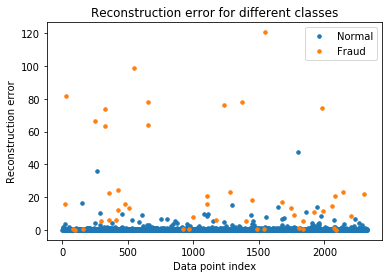

In [9]:
#get the best autoencoder.
best_autoencoder = grid_result.best_estimator_.model

# plot reconstruction error on the validation set
x_val_rec = best_autoencoder.predict(x_val)

mse_val = np.mean(np.power(x_val - x_val_rec, 2), axis=1)

val_pred_df = pd.DataFrame({'reconstruction_error': mse_val, 'true_class': y_val})

groups = val_pred_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
#ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


## Choose the right threshold

We **must** use the validation set in order to select the most suitable threshold.

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

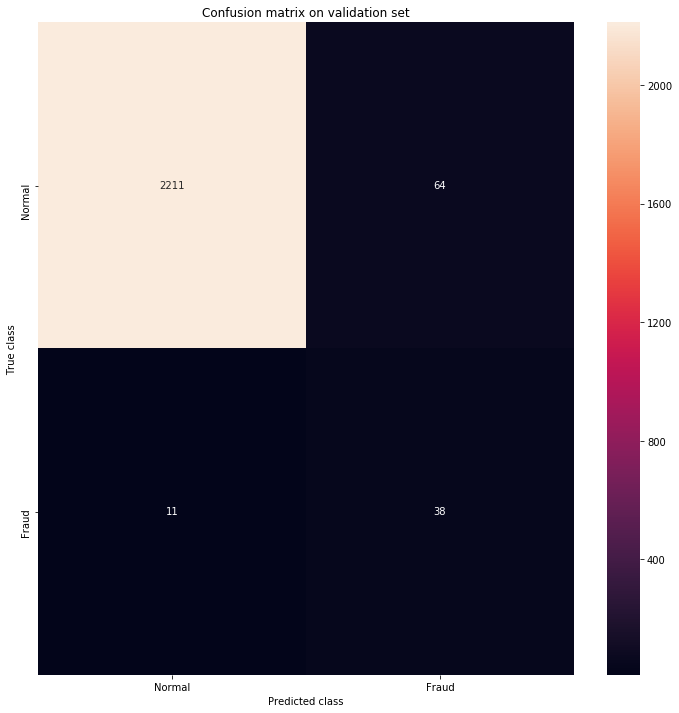

In [11]:
threshold = 2
y_val_pred = [1 if e > threshold else 0 for e in mse_val]
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
#plt.matshow(conf_matrix)
plt.title("Confusion matrix on validation set")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Evaluate the model on the test set

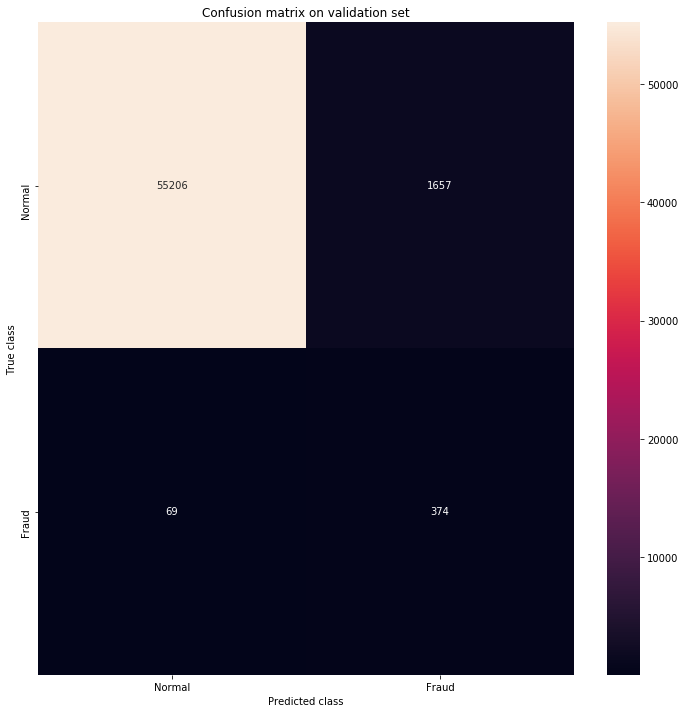

In [12]:
x_test_rec = best_autoencoder.predict(x_test)

mse_test = np.mean(np.power(x_test - x_test_rec, 2), axis=1)
y_test_pred = [1 if e > threshold else 0 for e in mse_test]
conf_matrix = confusion_matrix(y_test, y_test_pred)


plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
#plt.matshow(conf_matrix)
plt.title("Confusion matrix on validation set")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()